# Programming for Data Science and Artificial Intelligence

## Supervised Learning - Classification - Naive Bayesian - Multinomial

### Readings: 
- [VANDER] Ch5
- [HASTIE] Ch6

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Multinomial Naive Classification

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.  Another useful example is multinomial naive bayes, where the features are assumed to be generated from a simple multinomial distribution.  **The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive bayes is most appropriate for features that represent counts or count rates.**

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

One place where multinomial naive Bayes is often used is in **text classification**, where the features $w$ are related to word counts or frequencies within the documents to be classified and $y$ will be our class.  The formation is as follows:

$$
P(y|w) = \frac{P(w|y)P(y)}{P(w)}
$$

Before we proceed, let's define some notations: $d$ stands for number of documents, $V$ stands for number of unique vocabulary

**Implementation steps**: 

1. Prepare your data
    - X and y in the right shape
        - $X$ -> $(m, n)$
        - $y$ -> $(m,  )$
        - Note that theta is not needed.  Why?
    - train-test split
    - feature scale
    - clean out any missing data
    - (optional) feature engineering
    
2. Using the train documents, calculate the **likelihoods** of each word.  Following multinomial distribution, for a given word $w_i$, we count how many of $w_i$ belong in class $k$, we then divide this by ALL the words that belong to $k$. This gives us the conditional probability for a word $w$ given $k$:

    $$ P(w_i \in train \mid y=k) = \frac{count(w_i \in train, k)}{\Sigma_{i=1}^{V} count(w_i \in train, k)} $$
    
3. Since nothing in this world has zero probability, similarly, even we never see a particular word in some class should not gaurantee a zero probability, thus we can perform **Laplace smoothing** to account for any words with zero count
    $$ P(w_i \in train \mid y=k) = \frac{count(w_i \in train, k) + 1}{\Sigma_{i=1}^{V} count(w_i \in train, k) + V} $$

4. Once we get the **likelihoods** from the train data.  If given some test data, we simply use this likelihood to calculate the total likelihood of the test document.  Similarly, since we have more than one word in the test document, we need to make a product of all likelihood of each word in the test document.
    $$P(w \in test \mid y=k) = \prod_{i=1}^{pos} p(w_i \in test \mid y=k)$$
    - Note that $pos$ indicates the index of each word in the test document
    - Also note that if we have words occuring multiple times in the test document, we simply multiply that word's likelihood multiple times.  This can also be expressed as an equation where the word frequency is the power of the likelihood of the word $i$ like this:
    $$ P(w \in test \mid y=k) = \prod_{i=1}^{V} p(w_i \in test \mid y=k)^{\text{freq of }w_i \in test}$$
    
5. Find **priors** $P(y)$ where is simply number of documents belonging to that class divided by all documents

$$P(y = k) = \frac{\Sigma_{i=1}^{d}1(y=k)}{d} $$

6. To use our (4) and (5) information for prediction, we can multiply $P(y)P(w \in test \mid y)$ for each class which will give us $p(y \mid x)$ (**posteriors**)

$$P(y=k)P(w \in test \mid y=k)$$ or

$$P(y=k)\prod_{i=1}^{V} p(w_i \in test \mid y=k)^{\text{freq of }w_i \in test}$$

7. Instead of probabilities, we gonna use log (base e) probabiities which have several benefits:
    - **Speed** - Log probabilities become addition, which is faster than multiplication
    - **Stability** - Probabilities can be too small where some significant digits can be lost during calculations. Log probabiities can prevent such underflow.  If you don't believe me, try perform $log_e(0.0000001)$ (BTW, $log_e$ is same as $ln$)
    - **Simplicity** - Many distributions have exponential form.  Taking log cancels out the exp.  The reason we can apply $log$ is because $log$ is a monotically increasing function, thus will not alter the result 
    - **Dot product** - After log, addition can often expressed as dot product of matrix, simplifying the code implementation
    
   Now that you are convinced, 
   
   $$P(y=k)\prod_{i=1}^{V} p(w_i \in test \mid y=k)^{\text{freq of }w_i \in test}$$  becomes
   
  $$log \ P(y=k) + (\text{freq of }w_i \in test) * \Sigma_{i=1}^{V} log \ p(w_i \in test \mid y=k)$$
  - Note 1: Log of multiplication becomes addition
  - Note 2: Exponent of log becomes multiplicative scalar
  
8. Thus, in implementation we can expressed as

<code>np.log(priors) + X_test @ np.log(likelihoods.T) </code>

where <code>X_test</code> has been engineered/transformed in such a way that it represents the frequency of words

9. Now, you will have $k$ number of posteriors for the test document.  Simply take the biggest one or <code>argmax</code>. Note that we can ignore $P(x)$ since they can be canceled on both sides.

### Scratch

#### 1. Prepare some data

Here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names.

In [15]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Also, for simplicity here, we will select just a few of these categories, and download the training and testing set.

In [16]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Last, we will print some example data.

In [17]:
print(train.data[0]) #first 300 words
print("Target: ", train.target[0])  #start with 1, soc.religion.christian

From: jono@mac-ak-24.rtsg.mot.com (Jon Ogden)
Subject: Re: Losing your temper is not a Christian trait
Organization: Motorola LPA Development
Lines: 26

In article <Apr.23.02.55.47.1993.3138@geneva.rutgers.edu>, jcj@tellabs.com
(jcj) wrote:

> I'd like to remind people of the withering of the fig tree and Jesus
> driving the money changers et. al. out of the temple.  I think those
> were two instances of Christ showing anger (as part of His human side).
> 
Yes, and what about Paul saying:

26 Be ye angry, and sin not: let not the sun go down upon your wrath:
(Ephesians 4:26).

Obviously then, we can be angry w/o sinning.

Jon

------------------------------------------------
Jon Ogden         - jono@mac-ak-24.rtsg.mot.com
Motorola Cellular - Advanced Products Division
Voice: 708-632-2521      Data: 708-632-6086
------------------------------------------------

They drew a circle and shut him out.
Heretic, Rebel, a thing to flout.
But Love and I had the wit to win;
We drew a circle and 

#### TfidVectorizer

Recall that in Naive Multinomial Classification, we want our features to be represented as frequency.  That is, we must feature engineer our input to be frequency, with each feature (column) representing the frequency of each word.  Of course, we will then have a lot of features like 1000+ depending the number of unique words in our train documents.  Thus, our X can be expressed in shape of $(m, V)$

Here, we shall go beyond one more step, i.e., after counting the number of words, we shall perform a normalization process called TF-IDF which focuses on cutting less meaningful information like "the", "a", "is".

Before you get more confused, let's see how we can easily engineer our documents into frequency features using <code>sklearn.feature_extraction.text.CountVectorizer</code>

#### Let's first look at what is CountVectorizer

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print("Feature names: ", vectorizer.get_feature_names())
print("Type: ", type(X))
print(X.toarray())

vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names())

Feature names:  ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
Type:  <class 'scipy.sparse.csr.csr_matrix'>
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this', 'document is', 'first document', 'is the', 'is this', 'second document', 'the first', 'the second', 'the third', 'third one', 'this document', 'this is', 'this the']


#### Then let's look at what is TfidVectorizer

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

#imagine that we already have a frequency features.  We can perform normalization
#as a follow up
#here we got V=3, and d=6
counts = [[3, 0, 1],
          [2, 0, 0],
          [3, 0, 0],
          [4, 0, 0],
          [3, 2, 0],
          [3, 0, 2]]
transformer = TfidfTransformer()
transformer.fit_transform(counts).toarray()

array([[0.85151335, 0.        , 0.52433293],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.55422893, 0.83236428, 0.        ],
       [0.63035731, 0.        , 0.77630514]])

Some explaination first:

The formula is

$$ \text{TF-IDF}_{t} =  \text{TF} * \text{IDF} $$

where $t$ is each term, $\text{TF}$ is term frequency and $\text{IDF}$ is inverse document frequency which can be calculated as

$$ \text{IDF}(t) = log (\frac{d}{\text{DF}(t)}) + 1 $$

where $d$ is the total number of documents in the document set, $\text{DF}(t)$ is the number of documents in the document set that contain term $t$.

Then finally, it is normalized by Euclidean norm:

$$ norm(t_i) = \frac{t_i}{\sqrt{t_1^2 + t_2^2 + ....+t_V^2}} $$ 

For example, for first term (first column),

$$d = 6$$ 
$$\text{TF}(t)_{term1doc1} = 3$$

and for the $\text{DF}$, it appears in all 6 documents, thus 

$$\text{DF}(t)_{term1doc1} = 6$$ 

thus 

$$ \text{IDF}(t)_{term1doc1} = log (\frac{6}{6}) + 1 = 1$$

thus 

$$ \text{TF-IDF}_{term1doc1} = \text{TF} * \text{IDF} = 3 * 1 = 3 $$

For term 3 (row1, col3), you will get $\text{TF-IDF}(t)_{term3doc1} = 1 * (log (\frac{6}{2}) + 1) = 2.0986$

To normalize, simply do 

$$ t_{norm} = \frac{[3, 0, 2.0986]}{\sqrt{3^2 + 0^2 + 2.0986^2}} = [0.8515, 0, 0.5243]$$ 

Now that you understand what is inverse term frequency which is commonly used on document analysis.  Let's build some pipeline and make predictions

#### 1.1 Transform our data to features of words

In [20]:
#transform our X to vectorized data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train.data)
X_test = vectorizer.transform(test.data)
X_test = X_test.toarray()  #vectorizer gives us a sparse matrix; convert back to dense matrix

y_train = train.target
y_test = test.target

print("X_train: ", X_train[0])
print("y_train: ", y_train[0])

X_train:    (0, 32091)	0.06323663474836895
  (0, 34604)	0.08159803733249359
  (0, 34678)	0.09386677538713814
  (0, 16025)	0.03747094887347767
  (0, 20341)	0.053494245686987386
  (0, 7576)	0.023103622260498138
  (0, 14421)	0.11160127553180954
  (0, 31753)	0.04723937857426608
  (0, 26646)	0.10407682226672788
  (0, 16493)	0.1013912286522198
  (0, 16610)	0.09009773712773926
  (0, 29122)	0.08293805016995441
  (0, 8666)	0.16073965513378285
  (0, 12166)	0.19824118320941841
  (0, 31737)	0.02793242388131909
  (0, 2645)	0.11160127553180954
  (0, 10677)	0.054075767940987195
  (0, 1631)	0.10407682226672788
  (0, 2691)	0.2147274464147697
  (0, 2879)	0.19430735265559024
  (0, 33990)	0.07272800329036469
  (0, 11891)	0.07720124038682384
  (0, 25675)	0.07344668162795868
  (0, 4416)	0.07541359690487275
  (0, 8236)	0.11160127553180954
  :	:
  (0, 1655)	0.17106199151977294
  (0, 20065)	0.014736824020982909
  (0, 11327)	0.062343635038980855
  (0, 20366)	0.10407682226672788
  (0, 22013)	0.15958421417931642


#### 2 to 5:Calculating likelihood anrd prior

In [21]:
def likelihood(X_class, laplace=1):
    #sklearn called alpha
    return ((X_class.sum(axis=0)) + laplace) / (np.sum(X_class.sum(axis=0) + laplace))

In [22]:
def prior(X_class, m):
    return X_class.shape[0] / m

In [23]:
def fit(X_train, y_train):
    m, n = X_train.shape
    classes = np.unique(y_train)  #list of class
    k = len(classes) #number of class
    
    priors = np.zeros(k) #prior for each classes
    likelihoods = np.zeros((k, n)) #likehood for each class of each feature
    
    for idx, label in enumerate(classes):
        X_train_c = X_train[y_train==label]
        priors[idx] = prior(X_train_c, m)
        likelihoods[idx, :] = likelihood(X_train_c)
    return priors, likelihoods

#### 7. Log probabilities (I just skip 6)

In [24]:
def predict(X_test, priors, likelihoods, classes):
    return np.log(priors) + X_test @ np.log(likelihoods.T) 

#### 8. Let's use them

In [25]:
priors, likelihoods = fit(X_train, y_train)

In [26]:
classes = np.unique(y_test)
print("Classes: ", classes)
print("X_test shape: ", X_test.shape)
print("priors shape: ", priors.shape)
print("likelihoods shape: ", likelihoods.shape)
print("X_test @ np.log(likelihoods.T) shape: ", (X_test @ np.log(likelihoods.T) ).shape)
yhat = predict(X_test, priors, likelihoods, classes)

Classes:  [0 1 2 3]
X_test shape:  (1432, 35329)
priors shape:  (4,)
likelihoods shape:  (4, 35329)
X_test @ np.log(likelihoods.T) shape:  (1432, 4)


In [27]:
print("First two yhat samples: ", yhat[:2])
yhat = np.argmax(yhat, axis=1)
print("Yhat shape after argmax: ", yhat.shape)
print("First two yhat samples: ", yhat[:2])

First two yhat samples:  [[-91.43527546 -90.73890674 -88.35563902 -89.56907333]
 [-78.97708704 -79.86434517 -79.68980348 -81.16942474]]
Yhat shape after argmax:  (1432,)
First two yhat samples:  [2 0]


In [28]:
from sklearn.preprocessing import label_binarize

n_classes = len(np.unique(y_test))

print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))

print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)
    
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

Accuracy:  0.8016759776536313
=========Average precision score=======
Class 0 score:  0.888341920518241
Class 1 score:  0.8744630809734135
Class 2 score:  0.6122064043881043
Class 3 score:  0.332994836297269
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.97      0.88      0.92       389
           1       0.92      0.92      0.92       394
           2       0.62      0.98      0.76       398
           3       1.00      0.19      0.32       251

    accuracy                           0.80      1432
   macro avg       0.88      0.75      0.73      1432
weighted avg       0.86      0.80      0.77      1432



### Sklearn

In [29]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)
yhat = model.predict(X_test)  ##later for checking score

In [30]:
#fun thing you can do
some_string = "Programming is fun"
transformed = vectorizer.transform([some_string])
transformed.shape

prediction = model.predict(transformed)
print(train.target_names[prediction[0]])

comp.graphics


Text(32.99999999999999, 0.5, 'predicted')

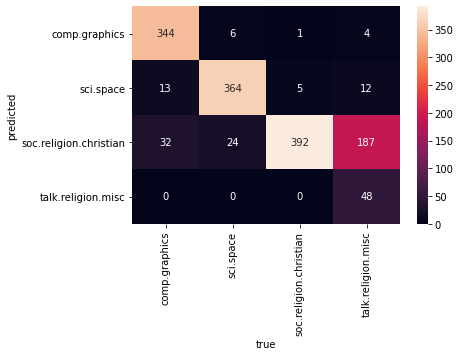

In [31]:
from sklearn.metrics import confusion_matrix

#use confusion matrix
mat = confusion_matrix(y_test, yhat)

import seaborn as sns
sns.heatmap(mat.T, annot=True, fmt="d",
           xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true')
plt.ylabel('predicted')

Looking above, it seems the accuracy is quite ok, but religion talk was often confused with christianity talk which kinda make sense.

Fun part is we can reuse the model.predict to predict any text.

In [32]:
print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

n_classes = len(np.unique(y_test))

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)

print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

=========Average precision score=======
Class 0 score:  0.888341920518241
Class 1 score:  0.8744630809734135
Class 2 score:  0.6122064043881043
Class 3 score:  0.332994836297269
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.97      0.88      0.92       389
           1       0.92      0.92      0.92       394
           2       0.62      0.98      0.76       398
           3       1.00      0.19      0.32       251

    accuracy                           0.80      1432
   macro avg       0.88      0.75      0.73      1432
weighted avg       0.86      0.80      0.77      1432



### When to Use Naive Bayes

Usually only as baseline!  Because naive Bayesian classifiers make such stringent assumptions about data, they will **generally NOT perform as well as a more complicated model.**
That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters

Naive Bayes classifiers tend to perform well only when your data is clearly separable or has high dimension.

The reason for high dimension is because new dimensions usually add more information, thus data become more separable.  Thus, if you have really large dataset, try Naive Bayes and it may surprise you!